In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.connect_db()

## Import Tables Needed

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)
bga8.drop_duplicates(['plant_id','boiler_id','generator_id'],inplace=True)

In [5]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
primary_fuel9 = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

In [6]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date'])
bf9_plant_summed.reset_index(inplace=True)

## Boiler Generator Association Exploration

In [24]:
def gens_with_bga(bga8=bga8,g9_summed=g9_summed):
    """ This section generates heat rate from the generators
    of the plants that have any generators that are not
    included in the boiler generator association table (860)
    Because there are missing generators in the bga table,
    without lumping all of the heat input and generation
    from these plants together, the heat rates were off. 
    The vast majority of missing generators from the bga
    table seem to be the gas tubrine from combine cycle plants.
    This was generating heat rates for the steam generators
    alone, therefor much too low."""
    # All cenerators from the Boiler Generator Association table (860)
    gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])
    # All cenerators from the generation table (923)/
    gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

    # See which generators are missing from the bga table
    gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
    gens.boiler_id = gens.boiler_id.astype(str)
    gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

    # Create a list of plants that include any generators that are not in the bga table
    unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                          drop_duplicates(subset=['plant_id','report_date']).\
                          drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)
    unassociated_plants['plant_assn'] = False

    # Using these unassociated_plants, lable all the generators that
    # are a part of plants that have generators that are not included
    # in the bga table
    gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')
    gens['plant_assn'] = gens.plant_assn.fillna(value=True)

    # Using the associtated plants, extract the generator/boiler combos
    # that represent complete plants at any time to preserve 
    # associations (i.e. if a coal plant had its boilers and generators
    # fully associated in the bga table in 2011 and then adds a
    # combined cycle plant the coal boiler/gen combo will be saved). 
    gens_complete = gens[['plant_id','generator_id','boiler_id','boiler_generator_assn','plant_assn']]
    gens_complete = gens_complete[gens_complete['plant_assn'] == True].drop_duplicates(subset=['plant_id','generator_id','boiler_id'])
    gens_complete['complete_assn'] = True
    gens = gens.merge(gens_complete[['plant_id','generator_id','boiler_id','complete_assn']], how='left', on=['plant_id','generator_id','boiler_id'])
    gens['complete_assn'] = gens.complete_assn.fillna(value=False)
    return(gens)

In [25]:
gens = gens_with_bga()

In [7]:
# This section generates heat rate from the generators
# of the plants that have any generators that are not
# included in the boiler generator association table (860)
# Because there are missing generators in the bga table,
# without lumping all of the heat input and generation
# from these plants together, the heat rates were off. 
# The vast majority of missing generators from the bga
# table seem to be the gas tubrine from combine cycle plants.
# This was generating heat rates for the steam generators
# alone, therefor much too low.

In [8]:
# All cenerators from the Boiler Generator Association table (860)
gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])
# All cenerators from the generation table (923)/
gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

# See which generators are missing from the bga table
gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
gens.boiler_id = gens.boiler_id.astype(str)
gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

# Create a list of plants that include any generators that are not in the bga table
unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                      drop_duplicates(subset=['plant_id','report_date']).\
                      drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)
unassociated_plants['plant_assn'] = False

# Using these unassociated_plants, lable all the generators that
# are a part of plants that have generators that are not included
# in the bga table
gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')
gens['plant_assn'] = gens.plant_assn.fillna(value=True)

# Using the associtated plants, extract the generator/boiler combos
# that represent complete plants at any time to preserve 
# associations (i.e. if a coal plant had its boilers and generators
# fully associated in the bga table in 2011 and then adds a
# combined cycle plant the coal boiler/gen combo will be saved). 
gens_complete = gens[['plant_id','generator_id','boiler_id','boiler_generator_assn','plant_assn']]
gens_complete = gens_complete[gens_complete['plant_assn'] == True].drop_duplicates(subset=['plant_id','generator_id','boiler_id'])
gens_complete['complete_assn'] = True
gens = gens.merge(gens_complete[['plant_id','generator_id','boiler_id','complete_assn']], how='left', on=['plant_id','generator_id','boiler_id'])
gens['complete_assn'] = gens.complete_assn.fillna(value=False)

## Unassociated Generators

In [30]:
def heat_rate(bf9_plant_summed=bf9_plant_summed):
    # This section pulls the unassociated generators
    gens = gens_with_bga()
    # Get a list of generators from plants with unassociated plants
    # gens_unassn_plants = gens[gens['plant_assn'] == False    
    gens_unassn_plants = gens[gens['complete_assn'] == False]

    # Sum the yearly net generation for these plants
    gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
    gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
    gens_unassn_plants_summed.reset_index(inplace=True)

    # Pull in mmbtu
    unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
    #calculate heat rate by plant
    unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

    # Merge these plant level heat heat rates with the unassociated generators
    # Assign heat rates to generators across the plants with unassociated generators
    heat_rate_unassn = gens_unassn_plants.merge(unassn_plants[['plant_id','report_date','heat_rate_mmbtu_mwh']], on=['plant_id','report_date'],how='left')
    heat_rate_unassn.drop(['boiler_id','boiler_generator_assn'],axis=1,inplace=True)
    
    # This section generates heat rate from the generators of
    # the plants that have any generators that are included in
    # the boiler generator association table (860)
    generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

    # get net generation per boiler
    gb1 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
    generation_w_boilers_summed = gb1.agg({'net_generation_mwh': np.sum})
    generation_w_boilers_summed.reset_index(inplace=True)
    generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

    # get the generation per boiler/generator combo
    gb2 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
    generation_w_bg_summed = gb2.agg({'net_generation_mwh': np.sum})
    generation_w_bg_summed.reset_index(inplace=True)
    generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

    # squish them together
    generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed,
                                                                    how='left', on=['plant_id','report_date','boiler_id'])

    bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])
    bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

    # Use the proportion of the generation of each generator to allot mmBTU
    bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
    bg['fuel_consumed_mmbtu_per_gen'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

    # Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
    bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
    bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_gen':np.sum})
    bg_summed.reset_index(inplace=True)

    # Calculate heat rate
    heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
    heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_gen'] / heat_rate['net_generation_mwh']

    # Importing the plant association tag to filter out the
    # generators that are a part of plants that aren't in the bga table
    heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','complete_assn','plant_assn']], on=['plant_id','report_date','generator_id'])
    heat_rate_assn = heat_rate[heat_rate['complete_assn'] == True]
    
    # Append heat rates for associated and unassociated 
    heat_rate_all = heat_rate_assn.append(heat_rate_unassn)
    heat_rate_all.sort_values(by=['plant_id','report_date','generator_id'],inplace=True)
    
    return(heat_rate_all)

In [31]:
heat_rate_all = heat_rate()

In [34]:
heat_rate_all.describe()

,fuel_consumed_mmbtu_per_gen,heat_rate_mmbtu_mwh,net_generation_mwh,plant_id,report_date
count,2.131300e+04,2.474600e+04,2.663800e+04,26638.000000,26638.000000
mean,7.697060e+06,inf,6.815793e+05,22764.563368,2012.714205
std,1.279147e+07,NaN,1.148993e+06,24258.226069,2.233399
min,-3.079700e+07,-1.659029e+04,-2.874970e+05,3.000000,2009.000000
25%,3.367244e+05,1.008872e+01,3.404400e+04,2291.000000,2011.000000
50%,2.246188e+06,1.160780e+01,2.007425e+05,7805.000000,2013.000000
75%,8.187508e+06,1.664127e+01,7.904050e+05,52089.000000,2015.000000
max,1.002326e+08,inf,1.030283e+07,60768.000000,2016.000000


In [9]:
# Get a list of generators from plants with unassociated plants
#gens_unassn_plants = gens[gens['plant_assn'] == False]
gens_unassn_plants = gens[gens['complete_assn'] == False]

# Sum the yearly net generation for these plants
gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
gens_unassn_plants_summed.reset_index(inplace=True)

# Pull in mmbtu to calculate heat rate by plant
unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

# Merge these plant level heat heat rates with the unassociated generators
# Assign heat rates to generators across the plants with unassociated generators
heat_rate_unassn = gens_unassn_plants.merge(unassn_plants[['plant_id','report_date','heat_rate_mmbtu_mwh']], on=['plant_id','report_date'],how='left')
heat_rate_unassn.drop(['boiler_id','boiler_generator_assn'],axis=1,inplace=True)

## Associated Generators

In [10]:
# This section generates heat rate from the generators of
# the plants that have any generators that are included in
# the boiler generator association table (860)

In [11]:
generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

# get net generation per boiler
gb1 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
generation_w_boilers_summed = gb1.agg({'net_generation_mwh': np.sum})
generation_w_boilers_summed.reset_index(inplace=True)
generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

# get the generation per boiler/generator combo
gb2 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
generation_w_bg_summed = gb2.agg({'net_generation_mwh': np.sum})
generation_w_bg_summed.reset_index(inplace=True)
generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

# squish them together
generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed,
                                                                how='left', on=['plant_id','report_date','boiler_id'])

# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])
bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

# Use the proportion of the generation of each generator to allot mmBTU
bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
bg['fuel_consumed_mmbtu_per_gen'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_gen':np.sum})
bg_summed.reset_index(inplace=True)

# Calculate heat rate
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_gen'] / heat_rate['net_generation_mwh']

# Importing the plant association tag to filter out the
# generators that are a part of plants that aren't in the bga table
heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','complete_assn','plant_assn']], on=['plant_id','report_date','generator_id'])
heat_rate_assn = heat_rate[heat_rate['complete_assn'] == True]

## Pull the Associated and Unassociated Generators

In [12]:
heat_rate_all = heat_rate_assn.append(heat_rate_unassn)
heat_rate_all.sort_values(by=['plant_id','report_date','generator_id'],inplace=True)

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


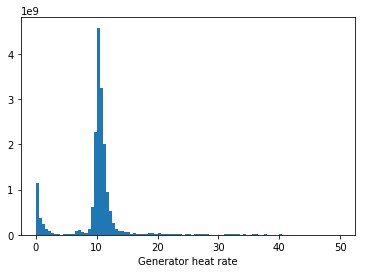

In [33]:
plt.hist(heat_rate_all.heat_rate_mmbtu_mwh, range=[0,50],bins=100,weights=heat_rate_all.net_generation_mwh)
#heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-20,70])
plt.xlabel('Generator heat rate')
plt.show()

In [27]:
heat_rate_all

,complete_assn,fuel_consumed_mmbtu_per_gen,generator_id,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_id,report_date
0,True,2.282135e+06,1,10.284149,221908.000,True,3,2009
1,True,4.047126e+06,2,10.271086,394031.000,True,3,2009
2,True,1.306599e+07,3,10.157073,1286393.000,True,3,2009
3,True,1.616073e+07,4,9.935606,1626547.000,True,3,2009
4,True,4.470910e+07,5,9.906513,4513101.000,True,3,2009
5,True,1.760776e+05,A1ST,0.156834,1122697.000,True,3,2009
6,True,1.373917e+05,A2ST,0.132908,1033733.000,True,3,2009
7,True,4.524332e+06,1,10.392783,435334.000,True,3,2010
8,True,5.721033e+06,2,10.624116,538495.000,True,3,2010
9,True,9.570256e+06,3,10.559444,906322.000,True,3,2010
